# Setup

In [1]:
from torch import Tensor
import torch
from numpy import ndarray as array
from numpy import random

from helper import to_2d

from typing import List, Tuple

### Assertions

In [2]:
def assert_same_shape(output: Tensor, 
                      output_grad: Tensor):
    assert output.shape == output_grad.shape, \
    '''
    Two tensors should have the same shape; instead, first Tensor's shape is {0}
    and second Tensor's shape is {1}.
    '''.format(tuple(output_grad.shape), tuple(output.shape))
    return None

In [3]:
def assert_dim(tensor: Tensor, 
               dim: int):
    assert tensor.dim() == dim, \
    '''
    Tensor should have dimension {0}, instead it has dimension {1}
    '''.format(dim, tensor.dim())
    return None

## `Layer` base class

In [4]:
class Operation(object):

    def __init__(self):
        raise NotImplementedError()
    
    def forward(self, input_: Tensor) -> Tensor:
        raise NotImplementedError()

    def backward(self, output_grad: Tensor) -> Tensor:
        raise NotImplementedError()

In [5]:
class ParamOperation(Operation):

    def __init__(self, param: Tensor) -> Tensor:
        super().__init__()
        self.param = param
        
    def _param_grad(self, output_grad: Tensor) -> Tensor:
        raise NotImplementedError()

In [6]:
class WeightMultiply(ParamOperation):

    def __init__(self, 
                 W: Tensor, 
                 param_name: str='W'):
        self.param = W
        self.param_name = param_name
    
    def forward(self, 
                input_: Tensor):
        self.input_ = input_

        # Lines specific to this layer
        assert self.input_.shape[1] == self.param.shape[0], \
        "Mismatch of shapes in WeightMultiply operation"
    
        self.output = torch.mm(input_, self.param)

        return self.output

    def backward(self, 
                 output_grad: Tensor):
        assert_same_shape(self.output, output_grad)

        # Lines specific to this layer        
        input_grad = torch.mm(output_grad, self.param.transpose(0, 1))
        
        self.param_grad = self._param_grad(output_grad)
        
        assert_same_shape(self.input_, input_grad)
        return input_grad
    
    def _param_grad(self, 
                    output_grad: Tensor):

        # Lines specific to this layer 
        param_grad = torch.mm(self.input_.transpose(0, 1), output_grad)
        
        assert_same_shape(self.param, param_grad)
        return param_grad

In [7]:
class BiasAdd(ParamOperation):

    def __init__(self, 
                 B: Tensor,
                 param_name: str='B'):
        self.param = B
        self.param_name = param_name
    
    def forward(self, 
                input_: Tensor):
        self.input_ = input_
        
        # Lines specific to this layer         
        assert self.input_.shape[1] == self.param.shape[1], \
        "Mismatch of shapes in BiasAdd operation"
        self.output = torch.add(self.input_, self.param)
        
        return self.output

    def backward(self, 
                 output_grad: Tensor):
        assert_same_shape(self.output, output_grad)
        
        input_grad = torch.ones_like(self.input_) * output_grad
        
        self.param_grad = self._param_grad(output_grad)
        
        assert_same_shape(self.input_, input_grad)
        return input_grad
    
    def _param_grad(self, 
                   output_grad: Tensor):

        param_grad = torch.ones_like(self.param) * output_grad
        
        param_grad = torch.sum(param_grad, dim=0).reshape(1, param_grad.shape[1])
        
        assert_same_shape(self.param, param_grad)
        return param_grad

In [8]:
class Activation(Operation):
    '''
    Sigmoid activation function
    '''
    def __init__(self) -> None:
        super().__init__()

In [9]:
class Sigmoid(Activation):
    '''
    Sigmoid activation function
    '''
    def __init__(self) -> None:
        pass
        
    def forward(self, 
                input_: Tensor) -> Tensor:
        
        self.input_ = input_
        
        self.output = 1.0/(1.0+torch.exp(-1.0 * input_))
        
        return self.output

    def backward(self, 
                 output_grad: Tensor) -> Tensor:

        assert_same_shape(self.output, output_grad)           
        
        sigmoid_backward = self.output*(1.0-self.output)
        
        input_grad = sigmoid_backward * output_grad
        
        assert_same_shape(self.input_, input_grad)
        
        return input_grad

In [10]:
class LinearAct(Activation):
    '''
    Sigmoid activation function
    '''
    def __init__(self) -> None:
        pass
        
    def forward(self, 
                input_: Tensor) -> Tensor:
        
        self.input_ = input_
        
        self.output = input_
        
        return self.output

    def backward(self, 
                 output_grad: Tensor) -> Tensor:

        assert_same_shape(self.output, output_grad)           
        
        input_grad = output_grad
        
        assert_same_shape(self.input_, input_grad)
        
        return input_grad

In [11]:
class Layer(object):

    def __init__(self, 
                 neurons: int) -> None:
        self.neurons = neurons
        self.first = True
        self.params: Dict[str, Tensor] = {}
        self.param_grads: Dict[str, Tensor] = {}

    def _setup_layer(self, num_in: int) -> None:
        pass
        
    def forward(self, input_: Tensor) -> Tensor:
        if self.first:
            self._setup_layer(input_.shape[1])
            self.first = False            
        self.input_ = input_
        
        for operation in self.operations:

            input_ = operation.forward(input_)
            
        self.output = input_

        return self.output

    def backward(self, output_grad: Tensor) -> Tensor:
        
        assert_same_shape(self.output, output_grad)
        
        for operation in self.operations[::-1]:
            output_grad = operation.backward(output_grad)
            
        input_grad = output_grad
        
        assert_same_shape(self.input_, input_grad)        
        
        self._param_grads()
        
        return input_grad
        
    def _param_grads(self, output_grad: Tensor) -> Tensor:

        for operation in operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads[operation.param_name] = operation.param_grad
                
    def update_params(self,   
                      learning_rate: float) -> None:

        for param in self.params.keys():
            self.params[param] -= learning_rate * self.param_grads[param]        
        


In [12]:
class Linear(Layer):

    def __init__(self, 
                 neurons: int, 
                 activation: Activation = None) -> None:
        self.neurons = neurons
        self.activation = activation
        self.first = True
        self.params: Dict[str, Tensor] = {}
        self.param_grads: Dict[str, Tensor] = {}

    def _setup_layer(self, num_in: int) -> None:
        self.params['W'] = torch.empty(num_in, self.neurons).uniform_(-1, 1)
        self.params['B'] = torch.empty(1, self.neurons).uniform_(-1, 1)
        self.operations = [WeightMultiply(self.params['W']), 
                           BiasAdd(self.params['B'])] + [self.activation]
        
    def forward(self, input_: Tensor) -> Tensor:
        if self.first:
            self._setup_layer(input_.shape[1])
            self.first = False            
        self.input_ = input_
        
        for operation in self.operations:

            input_ = operation.forward(input_)
            
        self.output = input_

        return self.output

    def backward(self, output_grad: Tensor) -> Tensor:
        
        assert_same_shape(self.output, output_grad)
        
        for operation in self.operations[::-1]:
            output_grad = operation.backward(output_grad)
            
        input_grad = output_grad
        
        assert_same_shape(self.input_, input_grad)        
        
        self._param_grads()
        
        return input_grad
        
    def _param_grads(self) -> Tensor:

        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads[operation.param_name] = operation.param_grad
                
    def update_params(self, 
                      learning_rate: float) -> None:

        for param in self.params.keys():
            self.params[param] -= learning_rate * self.param_grads[param]

In [13]:
class Loss(object):

    def __init__(self) -> None:
        pass
    
    
    def loss_grad(self, 
                  prediction: Tensor, 
                  target: Tensor) -> float:
        raise NotImplementedError()

In [14]:
class MeanSquaredError(Loss):

    def __init__(self) -> None:
        pass
    
    
    def loss_gradient(self, 
                      prediction: Tensor, 
                      target: Tensor) -> Tensor:
        loss = torch.sum(torch.pow(prediction - target, 2))
        
        loss_grad = -2.0 * torch.add(target, -1.0 * prediction)
        
        self.loss_grad = loss_grad
        
        assert_same_shape(prediction, loss_grad)
        
        return loss      

In [15]:
class NeuralNetwork:
    '''
    Neural network class. All the functions here are pretty straightforward.
    '''
    def __init__(self, layers: List[Layer], 
                 loss: Loss, 
                 learning_rate: float = 0.01) -> None:
        self.layers = layers
        self.loss = loss
        self.learning_rate = learning_rate
        
    def forward(self, X_batch: Tensor) -> Tensor:
        
        X_out = X_batch
        for layer in self.layers:
            X_out = layer.forward(X_out)

        return X_out
    
    def forward_loss(self, 
                     X_batch: Tensor, 
                     y_batch: Tensor) -> float:
        
        prediction = self.forward(X_batch)
        return self.loss.loss_gradient(prediction, y_batch)
    
    def backward(self, loss_grad: Tensor) -> None:
    
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
            
        return None
    
    def train_batch(self, 
                    X_batch: Tensor,
                    y_batch: Tensor) -> float:
        
        loss = self.forward_loss(X_batch, y_batch)
        
        self.backward(self.loss.loss_grad)
        
        self.update_params()
        
        return loss
    
            
    def update_params(self) -> None:
        for layer in self.layers:
            layer.update_params(self.learning_rate)
            


# Boston dataset

In [16]:
from sklearn.datasets import load_boston

In [17]:
boston = load_boston()

In [18]:
data = boston.data
target = boston.target
features = boston.feature_names

In [19]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

In [21]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [22]:
from helper import to_2d

In [23]:
def permute_data(X, y):
    perm = torch.randperm(X.shape[0])
    return X[perm], y[perm]

In [24]:
Batch = Tuple[Tensor, Tensor]

def generate_batch(X: Tensor, 
                   y: Tensor,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    
    assert (X.dim() == 2) and (y.dim() == 2), \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [25]:
def train(nn: NeuralNetwork,
          X: Tensor, 
          y: Tensor,
          n_iter: int = 1000,
          print_every: int = 100,
          batch_size: int = 100, 
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    y = to_2d(y, "col")
    start = 0

    # Permute data
    X, y = permute_data(X, y)

    losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        loss = nn.train_batch(X_batch, y_batch)
        if i % print_every == 0 and i != 0:
            print(loss)
        
        losses.append(loss)

    return losses
    

### Training loop

In [26]:
num_iter = 10000
print_every = 10000

In [27]:
lr = NeuralNetwork(
    layers=[Linear(neurons=1, 
                   activation=LinearAct())],
    loss=MeanSquaredError(),
    learning_rate=0.0002,
)

train(lr, X_train, y_train, 
      n_iter = num_iter, 
      print_every = print_every, 
      batch_size = 23, 
      seed=80718);

In [28]:
def mae(y_true, y_pred):
    return round(torch.mean(torch.abs(y_true - y_pred)).item(), 4)

def mse(y_true, y_pred):
    return round(torch.mean(torch.pow(y_true - y_pred, 2)).item(), 4)

In [29]:
lr_preds_test = lr.forward(X_test).reshape(X_test.shape[0])

In [30]:
mae(y_test, lr_preds_test)

3.5751

In [31]:
mse(y_test, lr_preds_test)

25.5706

### Neural network regression

In [32]:
nn = NeuralNetwork(
    layers=[Linear(neurons=13, 
                   activation=Sigmoid()),
            Linear(neurons=1, 
                   activation=LinearAct())],
    loss=MeanSquaredError(),
    learning_rate=0.00001,
)

train(nn, X_train, y_train, 
      n_iter = 100000, 
      print_every = print_every, 
      batch_size = 23, 
      seed=80718);

tensor(300.4627)
tensor(257.7684)
tensor(481.6164)
tensor(258.4339)
tensor(272.9756)
tensor(195.5693)
tensor(139.1275)
tensor(81.1519)
tensor(81.4568)


In [33]:
nn_preds = nn.forward(X_test).reshape(X_test.shape[0])

In [34]:
mae(y_test, nn_preds)

2.1422

In [35]:
mse(y_test, nn_preds)

10.9543

### Deep Learning!

In [36]:
dl = NeuralNetwork(
    layers=[Linear(neurons=13, 
                   activation=Sigmoid()),
            Linear(neurons=13, 
                   activation=Sigmoid()),
            Linear(neurons=1, 
                   activation=LinearAct())],
    loss=MeanSquaredError(),
    learning_rate=0.00001,
)

train(dl, X_train, y_train, 
      n_iter = 100000, 
      print_every = print_every, 
      batch_size = 23, 
      seed=80718);

preds_test = dl.forward(X_test).reshape(X_test.shape[0])

print(mae(y_test, preds_test))

print(mse(y_test, preds_test))

tensor(125.0521)
tensor(145.8671)
tensor(114.6383)
tensor(434.4886)
tensor(155.5627)
tensor(164.6972)
tensor(83.1765)
tensor(71.0046)
tensor(61.4810)
2.0874
9.39


### Plotting!

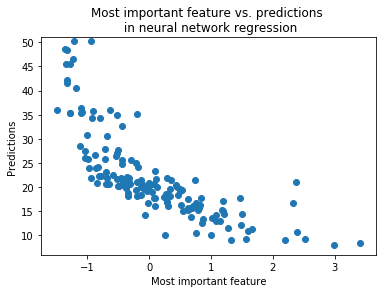

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X_test[:, 12], preds_test)
plt.ylim([6, 51])
plt.xlabel("Most important feature")
plt.ylabel("Predictions")
plt.title("Most important feature vs. predictions \n in neural network regression");


#### Theoretical relationship

In [38]:
import numpy as np

In [39]:
NUM = 50
a = np.zeros((NUM, 12))
b = np.linspace(-2.0, 3.5, NUM).reshape(NUM, 1)
test_feature = Tensor(np.concatenate([a, b], axis=1))
preds_test_theory = dl.forward(test_feature).reshape(test_feature.shape[0])

(6, 51)

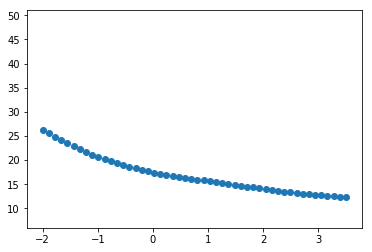

In [40]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds_test_theory))
plt.ylim([6, 51])